In [1]:
import time
import mrcfile
import numpy as np
import matplotlib.pyplot as plt

import fsc_utils as fsc

In [2]:
# You will need the 3-D volume and mask from: https://www.ebi.ac.uk/emdb/EMD-11657

map_file = ''
mask_file = ''

with mrcfile.open(map_file) as mrc:
    vol = mrc.data
    voxel = mrc.voxel_size.x
    mrc.close()
    
with mrcfile.open(mask_file) as mrc:
    mask = mrc.data
    mrc.close()
    
vol = vol * mask
img = vol.sum(axis=1)

N = img.shape[0]
r = N//2   
r_corner = int(np.ceil(np.sqrt(np.sum([s**2 for s in img.shape]))/2))

freq = fsc.get_radial_spatial_frequencies(img, voxel)

In [3]:
np.random.seed(0)

B_signal = 20
B_noise = 10
snr = 15

sigma = fsc.get_sigma_for_snr(img, snr)

img = fsc.apply_b_factor(img, voxel, B_signal)

eps1 = fsc.apply_b_factor(np.random.normal(0, sigma, img.shape), voxel, B_noise)
eps2 = fsc.apply_b_factor(np.random.normal(0, sigma, img.shape), voxel, B_noise)

In [4]:
### make a ctf similar to a tilt series image

def make_1d_ctf(r, d, shift=0):
    x = np.linspace(0, 2*np.pi, r)
    ctf = np.sin( (x**2 / d ) + shift)

    return ctf

def generate_2d_ctf_from_1d(ctf1d, r):
    
    ctf2d = np.zeros((N, N))
    rdists = fsc.radial_distance_grid([N,N])
    
    for ri in range(r):
        mask = fsc.shell_mask(rdists, ri)
        ctf2d[mask] = ctf1d[ri]
        
    return ctf2d

ctf1d = make_1d_ctf(r_corner, d=5, shift=3/4) 
ctf = generate_2d_ctf_from_1d(ctf1d, r_corner)

In [5]:
y1_ctf = fsc.ift2((ctf * fsc.ft2(img))) + eps1
y2_ctf = fsc.ift2((ctf * fsc.ft2(img))) + eps2

In [6]:
rdists = fsc.radial_distance_grid(img.shape)
sphere_mask = fsc.sphere_mask(rdists, 200)

eps_est = y1_ctf * ~sphere_mask
ratio = np.sum(~sphere_mask) / img.size

y1_whiten = fsc.whitening_transform(y1_ctf, eps_est, r_corner, ratio)
y1_upsample = fsc.fourier_upsample(y1_whiten, 2)

In [7]:
x_psd = fsc.compute_spherically_averaged_power_spectrum(img, r)
y1_ctf_psd = fsc.compute_spherically_averaged_power_spectrum(y1_ctf, r)

fsc_ctf = fsc.two_image_frc(y1_ctf, y2_ctf, r)
sfsc_upsample_ctf = np.mean(fsc.single_image_frc(y1_upsample, r, n_splits=1, whiten_upsample=True), axis=0)

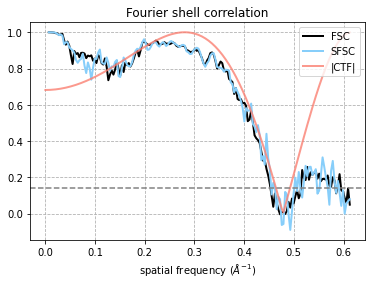

In [8]:
plt.figure(figsize=(6,4))
plt.plot(freq[2:], fsc_ctf[2:], color='k', linewidth=2, label='FSC')
plt.plot(freq[2:], sfsc_upsample_ctf[2:], color='lightskyblue', linewidth=2, alpha=1, label='SFSC')

plt.plot(freq, abs(ctf1d[:r]), color='salmon', linewidth=2, alpha=0.8, label='|CTF|')

plt.legend(loc=1)
plt.axhline(1/7, linestyle='--', color='gray')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.grid(which='major', linestyle='--')
plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('Fourier shell correlation')
# plt.savefig('')
plt.show()

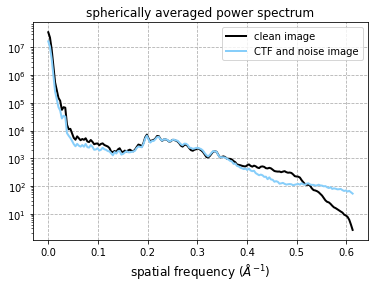

In [9]:
plt.figure(figsize=(6,4))

plt.semilogy(freq, x_psd, color='k', linewidth=2, label='clean image')
plt.semilogy(freq, y1_ctf_psd, color='lightskyblue', linewidth=2, label='CTF and noise image')

plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('spherically averaged power spectrum')

plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=10)

plt.grid(which='major', linestyle='--')
plt.legend()
# plt.savefig('')
plt.show()

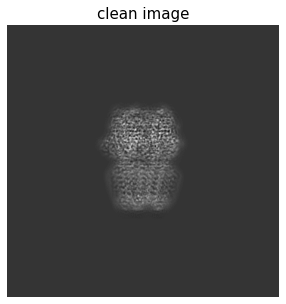

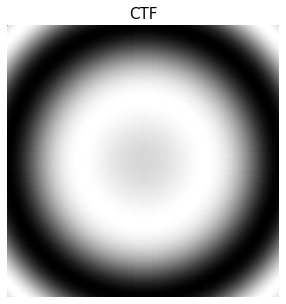

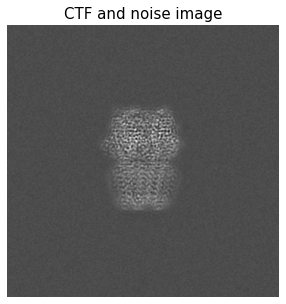

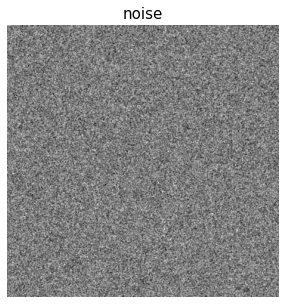

In [10]:
plt.figure(figsize=(5,5))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('clean image', fontsize=15)
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(ctf, cmap='gray')
plt.axis('off')
plt.title('CTF', fontsize=15)
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(y1_ctf, cmap='gray')
plt.axis('off')
plt.title('CTF and noise image', fontsize=15)
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(eps1, cmap='gray')
plt.axis('off')
plt.title('noise', fontsize=15)
# plt.savefig('')
plt.show()

In [11]:
# us a more realistic CTF from data folder

import pickle

with open('example_ctf.pkl', 'rb') as f:
    ctf_dict = pickle.load(f)
    
ctf = ctf_dict['CTF']

ctf1d = ctf[N//2, N//2:]

In [12]:
y1_ctf = fsc.ift2((ctf * fsc.ft2(img))) + eps1
y2_ctf = fsc.ift2((ctf * fsc.ft2(img))) + eps2

In [13]:
rdists = fsc.radial_distance_grid(img.shape)
sphere_mask = fsc.sphere_mask(rdists, 200)

eps_est = y1_ctf * ~sphere_mask
ratio = np.sum(~sphere_mask) / img.size

y1_whiten = fsc.whitening_transform(y1_ctf, eps_est, r_corner, ratio)
y1_upsample = fsc.fourier_upsample(y1_whiten, 2)

In [14]:
x_psd = fsc.compute_spherically_averaged_power_spectrum(img, r)
y1_ctf_psd = fsc.compute_spherically_averaged_power_spectrum(y1_ctf, r)

fsc_ctf = fsc.two_image_frc(y1_ctf, y2_ctf, r)
sfsc_upsample_ctf = np.mean(fsc.single_image_frc(y1_upsample, r, n_splits=1, whiten_upsample=True), axis=0)

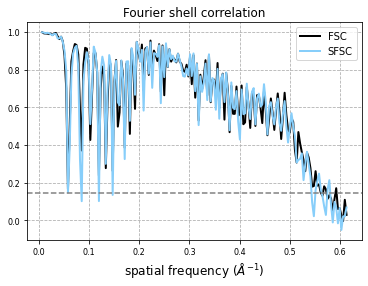

In [15]:
plt.figure(figsize=(6,4))
plt.plot(freq[2:], fsc_ctf[2:], color='k', linewidth=2, label='FSC')
plt.plot(freq[2:], sfsc_upsample_ctf[2:], color='lightskyblue', linewidth=2, alpha=1, label='SFSC') 

plt.legend(loc=1)
plt.axhline(1/7, linestyle='--', color='gray')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('legend', fontsize=10)
plt.grid(which='major', linestyle='--')
plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('Fourier shell correlation')
# plt.savefig('')
plt.show()

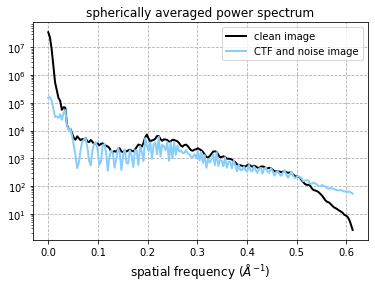

In [16]:
plt.figure(figsize=(6,4))

plt.semilogy(freq, x_psd, color='k', linewidth=2, label='clean image')
plt.semilogy(freq, y1_ctf_psd, color='lightskyblue', linewidth=2, label='CTF and noise image')

plt.xlabel('spatial frequency 'r'(${\AA}^{-1}$)')
plt.title('spherically averaged power spectrum')

plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('legend', fontsize=10)

plt.grid(which='major', linestyle='--')
plt.legend()
# plt.savefig('')
plt.show()

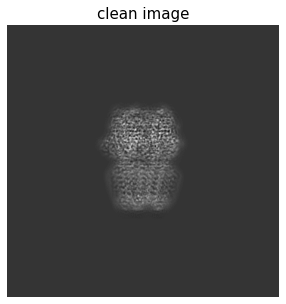

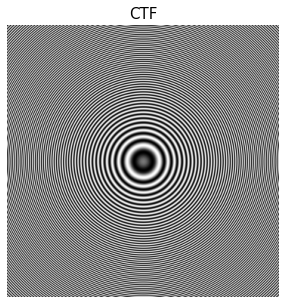

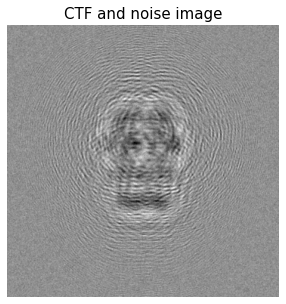

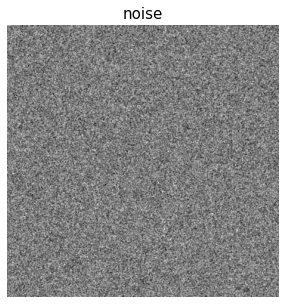

In [17]:
plt.figure(figsize=(5,5))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('clean image', fontsize=15)
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(ctf, cmap='gray')
plt.axis('off')
plt.title('CTF', fontsize=15)
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(y1_ctf, cmap='gray')
plt.axis('off')
plt.title('CTF and noise image', fontsize=15)
# plt.savefig('')
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(eps1, cmap='gray')
plt.axis('off')
plt.title('noise', fontsize=15)
# plt.savefig('')
plt.show()